# Arbor-Neuron validation output analysis

In [1]:
import re
import json
import pandas
import matplotlib.pyplot as plt
from IPython.display import display

Tests with OK status:

In [2]:
%%bash

rm tests_{ok,error,na} || true
grep test_l5pc\ OK l5pc_soma_arbor_* | tee tests_ok

l5pc_soma_arbor_all.ipynb:      "Default dt (0.025): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.00101 (0.05), 1.7e-08 (0.0005).\n"
l5pc_soma_arbor_all.ipynb:      "Fine dt (0.001): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.000381 (0.05), 2.13e-08 (0.0005).\n"
l5pc_soma_arbor_apical_Ih_Im.ipynb:      "Default dt (0.025): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.0031 (0.05), 6.19e-08 (0.0005).\n"
l5pc_soma_arbor_apical_Ih_Im.ipynb:      "Fine dt (0.001): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.000627 (0.05), 2.86e-06 (0.0005).\n"
l5pc_soma_arbor_apical_Ih_Im_NaTs2_t.ipynb:      "Default dt (0.025): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.00432 (0.05), 7.03e-08 (0.0005).\n"
l5pc_soma_arbor_apical_Ih_Im_NaTs2_t.ipynb:      "Fine dt (0.001):

Tests with ERROR status:

In [3]:
%%bash

grep test_l5pc\ ERROR l5pc_soma_arbor_* | tee tests_error

l5pc_soma_arbor_axonal_CaDynamics_E2_K_Tst.ipynb:      "Default dt (0.025): test_l5pc ERROR! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.685 (0.05), 3.21e-08 (0.0005).\n"
l5pc_soma_arbor_axonal_CaDynamics_E2_K_Tst.ipynb:      "Fine dt (0.001): test_l5pc ERROR! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.685 (0.05), 3.19e-08 (0.0005).\n"
l5pc_soma_arbor_axonal_CaDynamics_E2_K_Tst_NaTa_t.ipynb:      "Default dt (0.025): test_l5pc ERROR! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.624 (0.05), 5.05e-08 (0.0005).\n"
l5pc_soma_arbor_axonal_CaDynamics_E2_K_Tst_NaTa_t.ipynb:      "Fine dt (0.001): test_l5pc ERROR! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.625 (0.05), 6.9e-08 (0.0005).\n"
l5pc_soma_arbor_axonal_CaDynamics_E2_SK_E2_K_Tst.ipynb:      "Default dt (0.025): test_l5pc ERROR! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) ar

Tests with N/A result:

In [4]:
%%bash

touch tests_na
for f in $(ls l5pc_soma_arbor_*); do 
    if ! grep test_l5pc\ OK $f > /dev/null && ! grep test_l5pc\ ERROR $f > /dev/null; then 
        echo "$f" | tee -a tests_na
    fi
done

l5pc_soma_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb
l5pc_soma_arbor_axonal_Ca_HVA_CaDynamics_E2_K_Tst.ipynb
l5pc_soma_arbor_axonal_Ca_HVA_CaDynamics_E2_NaTa_t.ipynb
l5pc_soma_arbor_axonal_Ca_HVA_CaDynamics_E2_SK_E2.ipynb
l5pc_soma_arbor_axonal_Ca_LVAst_CaDynamics_E2.ipynb
l5pc_soma_arbor_axonal_Ca_LVAst_CaDynamics_E2_SK_E2.ipynb
l5pc_soma_arbor_axonal_Ca_LVAst_Ca_HVA_CaDynamics_E2.ipynb
l5pc_soma_arbor_somatic_CaDynamics_E2_Ca_HVA_Ca_LVAst.ipynb
l5pc_soma_arbor_somatic_CaDynamics_E2_Ca_HVA_Ih.ipynb
l5pc_soma_arbor_somatic_CaDynamics_E2_Ca_HVA.ipynb
l5pc_soma_arbor_somatic_CaDynamics_E2_Ca_LVAst_Ih.ipynb
l5pc_soma_arbor_somatic_CaDynamics_E2_Ca_LVAst.ipynb
l5pc_soma_arbor_somatic_NaTs2_t_CaDynamics_E2_Ca_HVA.ipynb
l5pc_soma_arbor_somatic_NaTs2_t_CaDynamics_E2_Ca_LVAst.ipynb


In [5]:
# Read output
with open('tests_ok') as f:
    tests_ok = f.readlines()

with open('tests_error') as f:
    tests_error = f.readlines()

with open('tests_na') as f:
    tests_na = f.readlines()

Display test results. Test status can be ERROR due to relative L1-norm exceeding the tolerance or, similarly, the quadrature error exceeding a lower threshold. 

In [6]:
def parse_test_status_line(line):
    numeric_vars = ['dt', 'l1_norm', 'l1_tol', 'l1_error', 'l1_error_tol']
    numbers = [r'(?P<{}>[+\-]?\d+[\.]?\d*[eE]?[+\-]?\d*)'.format(name) 
               for name in numeric_vars]
    test_status_pattern = r'^(?P<filename>l5pc_soma_arbor_\w+.ipynb):\s+\"(?P<dt_setting>Default|Fine) dt \({}\): test_l5pc (?P<test_result>OK|ERROR)! [\w\s-]+\(tol in brackets\) are {} \({}\), {} \({}\)'.format(*numbers)
    match = re.search(test_status_pattern, line)
    groupdict = match.groupdict()
    for v in numeric_vars:
        groupdict[v] = float(groupdict[v])
    return groupdict


# extract params from executed notebooks
def extract_mechs_params(filename):
    with open(filename) as f:
        nb = json.load(f)
    # print(nb['cells'][2]['source'])
    exec('global mechanism_defs\nglobal extra_params\n' + ''.join(nb['cells'][2]['source']))
    return mechanism_defs, extra_params


test_results = []
for line in tests_ok + tests_error:
    result = parse_test_status_line(line)
    region_mechs = result['filename'][len('l5pc_soma_arbor_'):-len('.ipynb')].split('_')
    result['region'] = region_mechs[0]
    result['mechs_str'] = '_'.join(region_mechs[1:])
    
    mechs, params = extract_mechs_params(result['filename'])    
    result['mechs'] = mechs
    result['extra_params'] = extra_params
    test_results.append(result)

test_status_df = pandas.DataFrame(test_results)
regional_test_status = dict()

max_rows_default = pandas.options.display.max_rows
pandas.options.display.max_rows = None  # uncomment for full view
for region, regional_test_status_df in test_status_df.groupby(['region']):
    regional_test_status[region] = regional_test_status_df.sort_values(by='l1_norm', ascending=False)
    display(regional_test_status[region])
pandas.options.display.max_rows = max_rows_default

,filename,dt_setting,dt,test_result,l1_norm,l1_tol,l1_error,l1_error_tol,region,mechs_str,mechs,extra_params
0,l5pc_soma_arbor_all.ipynb,Default,0.025,OK,0.001010,0.05,1.700000e-08,0.0005,all,,{'all': ['pas']},"{'v_init': 'global', 'celsius': 'global', 'g_p..."
1,l5pc_soma_arbor_all.ipynb,Fine,0.001,OK,0.000381,0.05,2.130000e-08,0.0005,all,,{'all': ['pas']},"{'v_init': 'global', 'celsius': 'global', 'g_p..."


,filename,dt_setting,dt,test_result,l1_norm,l1_tol,l1_error,l1_error_tol,region,mechs_str,mechs,extra_params
24,l5pc_soma_arbor_apical.ipynb,Default,0.025,OK,0.006480,0.05,1.090000e-07,0.0005,apical,,"{'all': ['pas'], 'apical': ['Ih', 'Im', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
22,l5pc_soma_arbor_apical_Im_SKv3_1_NaTs2_t.ipynb,Default,0.025,OK,0.006220,0.05,1.240000e-07,0.0005,apical,Im_SKv3_1_NaTs2_t,"{'all': ['pas'], 'apical': ['Im', 'SKv3_1', 'N...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
14,l5pc_soma_arbor_apical_Ih_SKv3_1_NaTs2_t.ipynb,Default,0.025,OK,0.006030,0.05,1.010000e-06,0.0005,apical,Ih_SKv3_1_NaTs2_t,"{'all': ['pas'], 'apical': ['Ih', 'SKv3_1', 'N...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
30,l5pc_soma_arbor_apical_SKv3_1_NaTs2_t.ipynb,Default,0.025,OK,0.005880,0.05,6.510000e-07,0.0005,apical,SKv3_1_NaTs2_t,"{'all': ['pas'], 'apical': ['SKv3_1', 'NaTs2_t']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
4,l5pc_soma_arbor_apical_Ih_Im_NaTs2_t.ipynb,Default,0.025,OK,0.004320,0.05,7.030000e-08,0.0005,apical,Ih_Im_NaTs2_t,"{'all': ['pas'], 'apical': ['Ih', 'Im', 'NaTs2...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
18,l5pc_soma_arbor_apical_Im_NaTs2_t.ipynb,Default,0.025,OK,0.004230,0.05,9.670000e-08,0.0005,apical,Im_NaTs2_t,"{'all': ['pas'], 'apical': ['Im', 'NaTs2_t']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
6,l5pc_soma_arbor_apical_Ih_Im_SKv3_1.ipynb,Default,0.025,OK,0.003600,0.05,5.710000e-08,0.0005,apical,Ih_Im_SKv3_1,"{'all': ['pas'], 'apical': ['Ih', 'Im', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
20,l5pc_soma_arbor_apical_Im_SKv3_1.ipynb,Default,0.025,OK,0.003490,0.05,1.990000e-07,0.0005,apical,Im_SKv3_1,"{'all': ['pas'], 'apical': ['Im', 'SKv3_1']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
12,l5pc_soma_arbor_apical_Ih_SKv3_1.ipynb,Default,0.025,OK,0.003370,0.05,2.710000e-07,0.0005,apical,Ih_SKv3_1,"{'all': ['pas'], 'apical': ['Ih', 'SKv3_1']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
28,l5pc_soma_arbor_apical_SKv3_1.ipynb,Default,0.025,OK,0.003200,0.05,2.170000e-07,0.0005,apical,SKv3_1,"{'all': ['pas'], 'apical': ['SKv3_1']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."


,filename,dt_setting,dt,test_result,l1_norm,l1_tol,l1_error,l1_error_tol,region,mechs_str,mechs,extra_params
344,l5pc_soma_arbor_axonal_Ca_LVAst_K_Tst.ipynb,Fine,0.001,ERROR,0.703000,0.05,2.440000e-08,0.0005,axonal,Ca_LVAst_K_Tst,"{'all': ['pas'], 'axonal': ['Ca_LVAst', 'K_Tst']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
343,l5pc_soma_arbor_axonal_Ca_LVAst_K_Tst.ipynb,Default,0.025,ERROR,0.702000,0.05,2.660000e-08,0.0005,axonal,Ca_LVAst_K_Tst,"{'all': ['pas'], 'axonal': ['Ca_LVAst', 'K_Tst']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
333,l5pc_soma_arbor_axonal_Ca_HVA_SK_E2_K_Tst.ipynb,Fine,0.001,ERROR,0.700000,0.05,2.390000e-08,0.0005,axonal,Ca_HVA_SK_E2_K_Tst,"{'all': ['pas'], 'axonal': ['Ca_HVA', 'SK_E2',...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
350,l5pc_soma_arbor_axonal_Ca_LVAst_SK_E2_K_Tst.ipynb,Fine,0.001,ERROR,0.700000,0.05,2.590000e-08,0.0005,axonal,Ca_LVAst_SK_E2_K_Tst,"{'all': ['pas'], 'axonal': ['Ca_LVAst', 'SK_E2...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
349,l5pc_soma_arbor_axonal_Ca_LVAst_SK_E2_K_Tst.ipynb,Default,0.025,ERROR,0.700000,0.05,2.380000e-08,0.0005,axonal,Ca_LVAst_SK_E2_K_Tst,"{'all': ['pas'], 'axonal': ['Ca_LVAst', 'SK_E2...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
332,l5pc_soma_arbor_axonal_Ca_HVA_SK_E2_K_Tst.ipynb,Default,0.025,ERROR,0.699000,0.05,2.300000e-08,0.0005,axonal,Ca_HVA_SK_E2_K_Tst,"{'all': ['pas'], 'axonal': ['Ca_HVA', 'SK_E2',...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
329,l5pc_soma_arbor_axonal_Ca_HVA_K_Tst.ipynb,Fine,0.001,ERROR,0.695000,0.05,2.890000e-08,0.0005,axonal,Ca_HVA_K_Tst,"{'all': ['pas'], 'axonal': ['Ca_HVA', 'K_Tst']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
328,l5pc_soma_arbor_axonal_Ca_HVA_K_Tst.ipynb,Default,0.025,ERROR,0.695000,0.05,2.710000e-08,0.0005,axonal,Ca_HVA_K_Tst,"{'all': ['pas'], 'axonal': ['Ca_HVA', 'K_Tst']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
338,l5pc_soma_arbor_axonal_Ca_LVAst_CaDynamics_E2_...,Default,0.025,ERROR,0.694000,0.05,2.300000e-08,0.0005,axonal,Ca_LVAst_CaDynamics_E2_K_Tst,"{'all': ['pas'], 'axonal': ['Ca_LVAst', 'CaDyn...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
339,l5pc_soma_arbor_axonal_Ca_LVAst_CaDynamics_E2_...,Fine,0.001,ERROR,0.694000,0.05,2.640000e-08,0.0005,axonal,Ca_LVAst_CaDynamics_E2_K_Tst,"{'all': ['pas'], 'axonal': ['Ca_LVAst', 'CaDyn...","{'v_init': 'global', 'celsius': 'global', 'g_p..."


,filename,dt_setting,dt,test_result,l1_norm,l1_tol,l1_error,l1_error_tol,region,mechs_str,mechs,extra_params
215,l5pc_soma_arbor_basal.ipynb,Default,0.025,OK,0.000871,0.05,1.340000e-08,0.0005,basal,,"{'all': ['pas'], 'basal': ['Ih']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
216,l5pc_soma_arbor_basal.ipynb,Fine,0.001,OK,0.000363,0.05,3.770000e-08,0.0005,basal,,"{'all': ['pas'], 'basal': ['Ih']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."


,filename,dt_setting,dt,test_result,l1_norm,l1_tol,l1_error,l1_error_tol,region,mechs_str,mechs,extra_params
381,l5pc_soma_arbor_somatic_NaTs2_t_SKv3_1_CaDynam...,Default,0.025,ERROR,0.109000,0.05,1.970000e-06,0.0005,somatic,NaTs2_t_SKv3_1_CaDynamics_E2,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
385,l5pc_soma_arbor_somatic_NaTs2_t_SKv3_1_Ca_LVAs...,Default,0.025,ERROR,0.107000,0.05,2.620000e-06,0.0005,somatic,NaTs2_t_SKv3_1_Ca_LVAst,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
391,l5pc_soma_arbor_somatic_NaTs2_t_SKv3_1_SK_E2.i...,Default,0.025,ERROR,0.106000,0.05,2.460000e-06,0.0005,somatic,NaTs2_t_SKv3_1_SK_E2,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
389,l5pc_soma_arbor_somatic_NaTs2_t_SKv3_1.ipynb,Default,0.025,ERROR,0.102000,0.05,2.500000e-06,0.0005,somatic,NaTs2_t_SKv3_1,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
383,l5pc_soma_arbor_somatic_NaTs2_t_SKv3_1_Ca_HVA....,Default,0.025,ERROR,0.102000,0.05,2.530000e-06,0.0005,somatic,NaTs2_t_SKv3_1_Ca_HVA,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
387,l5pc_soma_arbor_somatic_NaTs2_t_SKv3_1_Ih.ipynb,Default,0.025,ERROR,0.096900,0.05,2.590000e-06,0.0005,somatic,NaTs2_t_SKv3_1_Ih,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
287,l5pc_soma_arbor_somatic_SKv3_1_CaDynamics_E2_C...,Default,0.025,OK,0.044100,0.05,1.570000e-06,0.0005,somatic,SKv3_1_CaDynamics_E2_Ca_HVA,"{'all': ['pas'], 'somatic': ['SKv3_1', 'CaDyna...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
288,l5pc_soma_arbor_somatic_SKv3_1_CaDynamics_E2_C...,Fine,0.001,OK,0.040900,0.05,2.520000e-05,0.0005,somatic,SKv3_1_CaDynamics_E2_Ca_HVA,"{'all': ['pas'], 'somatic': ['SKv3_1', 'CaDyna...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
273,l5pc_soma_arbor_somatic_SK_E2_Ca_HVA_Ca_LVAst....,Default,0.025,OK,0.027900,0.05,1.810000e-08,0.0005,somatic,SK_E2_Ca_HVA_Ca_LVAst,"{'all': ['pas'], 'somatic': ['SK_E2', 'Ca_HVA'...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
274,l5pc_soma_arbor_somatic_SK_E2_Ca_HVA_Ca_LVAst....,Fine,0.001,OK,0.027500,0.05,2.130000e-08,0.0005,somatic,SK_E2_Ca_HVA_Ca_LVAst,"{'all': ['pas'], 'somatic': ['SK_E2', 'Ca_HVA'...","{'v_init': 'global', 'celsius': 'global', 'g_p..."


We can rank-order the mechs w.r.t. the L1-deviation on each region and for each `dt` configuration.

In [7]:
def regional_rank_stats(region, regional_test_status):
    regional_mechs = regional_test_status[regional_test_status['mechs_str'] == ''].iloc[0]['mechs'][region]
    regional_mech_ranks = {dt_setting: [] for dt_setting in regional_test_status_df['dt_setting'].unique()}
    for mech in regional_mechs:
        for dt_setting, dt_group in regional_test_status_df.groupby('dt_setting'):
            regional_mech_ranks[dt_setting].append(dict(region=region, dt_setting=dt_setting, mech=mech))
            rank_stats = 1./len(dt_group)*dt_group['l1_norm'].rank(ascending=False)[ dt_group.apply(lambda r: mech in r['mechs_str'], axis=1) ].describe()
            for k, v in rank_stats.items():
                regional_mech_ranks[dt_setting][-1]['rank_' + k] = v
    return {dt_setting: pandas.DataFrame(dt_group).sort_values(by='rank_mean') for dt_setting, dt_group in regional_mech_ranks.items()}

for region, regional_test_status_df in regional_test_status.items():
    for rank_stats in regional_rank_stats(region, regional_test_status[region]).values():
        display(rank_stats)

,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
0,all,Default,pas,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
0,all,Fine,pas,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
2,apical,Default,SKv3_1,0.466667,0.409524,0.208801,0.133333,0.233333,0.466667,0.566667,0.666667
3,apical,Default,NaTs2_t,0.466667,0.447619,0.321373,0.133333,0.233333,0.333333,0.633333,0.933333
1,apical,Default,Im,0.466667,0.485714,0.230022,0.133333,0.366667,0.466667,0.633333,0.800000
0,apical,Default,Ih,0.466667,0.609524,0.299205,0.200000,0.400000,0.600000,0.833333,1.000000


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
2,apical,Fine,SKv3_1,0.466667,0.361905,0.239929,0.066667,0.166667,0.333333,0.566667,0.666667
3,apical,Fine,NaTs2_t,0.466667,0.438095,0.346105,0.066667,0.166667,0.400000,0.666667,0.933333
1,apical,Fine,Im,0.466667,0.533333,0.203670,0.200000,0.433333,0.533333,0.666667,0.800000
0,apical,Fine,Ih,0.466667,0.580952,0.343650,0.066667,0.366667,0.533333,0.866667,1.000000


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
5,axonal,Fine,K_Tst,0.292683,0.261292,0.218623,0.008130,0.079268,0.150407,0.472561,0.609756
6,axonal,Fine,K_Pst,0.300813,0.365414,0.165189,0.130081,0.211382,0.357724,0.508130,0.658537
8,axonal,Fine,NaTa_t,0.292683,0.461608,0.283987,0.093496,0.250000,0.353659,0.758130,0.886179
4,axonal,Fine,SK_E2,0.284553,0.505110,0.288413,0.020325,0.280488,0.520325,0.727642,0.983740
0,axonal,Fine,Ca_LVAst,0.276423,0.511119,0.314661,0.008130,0.272358,0.467480,0.788618,1.000000
1,axonal,Fine,Ca_HVA,0.260163,0.531631,0.306851,0.020325,0.295732,0.487805,0.823171,0.991870
2,axonal,Fine,CaDynamics_E2,0.243902,0.536585,0.287192,0.040650,0.349593,0.514228,0.768293,0.975610
3,axonal,Fine,SKv3_1,0.300813,0.556471,0.194775,0.154472,0.430894,0.617886,0.691057,0.910569
7,axonal,Fine,Nap_Et2,0.300813,0.687321,0.294609,0.146341,0.581301,0.821138,0.926829,1.000000


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
5,axonal,Default,K_Tst,0.292683,0.286585,0.241565,0.008130,0.079268,0.199187,0.445122,0.699187
6,axonal,Default,K_Pst,0.300813,0.374094,0.148033,0.134146,0.252033,0.325203,0.504065,0.642276
8,axonal,Default,NaTa_t,0.292683,0.445912,0.310049,0.093496,0.160569,0.288618,0.768293,0.902439
4,axonal,Default,SK_E2,0.284553,0.505691,0.283581,0.016260,0.321138,0.520325,0.727642,0.987805
0,axonal,Default,Ca_LVAst,0.276423,0.512434,0.309877,0.008130,0.278455,0.479675,0.774390,1.000000
3,axonal,Default,SKv3_1,0.300813,0.525928,0.226024,0.134146,0.414634,0.569106,0.642276,0.910569
1,axonal,Default,Ca_HVA,0.260163,0.526550,0.298743,0.024390,0.325203,0.487805,0.807927,0.987805
2,axonal,Default,CaDynamics_E2,0.243902,0.530894,0.287217,0.040650,0.331301,0.520325,0.756098,0.975610
7,axonal,Default,Nap_Et2,0.300813,0.724127,0.275288,0.203252,0.674797,0.853659,0.926829,1.000000


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
0,basal,Default,Ih,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
0,basal,Fine,Ih,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
1,somatic,Default,SKv3_1,0.385965,0.315789,0.189476,0.017544,0.109649,0.377193,0.469298,0.561404
2,somatic,Default,SK_E2,0.385965,0.415470,0.238308,0.052632,0.236842,0.342105,0.635965,0.842105
0,somatic,Default,NaTs2_t,0.350877,0.475877,0.325923,0.017544,0.098684,0.609649,0.692982,0.921053
3,somatic,Default,CaDynamics_E2,0.263158,0.488304,0.274918,0.017544,0.245614,0.473684,0.692982,0.877193
5,somatic,Default,Ca_LVAst,0.315789,0.517544,0.293812,0.035088,0.285088,0.535088,0.745614,0.964912
4,somatic,Default,Ca_HVA,0.315789,0.535575,0.363492,0.078947,0.179825,0.500000,0.921053,1.000000
6,somatic,Default,Ih,0.350877,0.615351,0.263408,0.105263,0.399123,0.644737,0.828947,0.982456


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
1,somatic,Fine,SKv3_1,0.385965,0.340510,0.160829,0.017544,0.197368,0.377193,0.469298,0.578947
2,somatic,Fine,SK_E2,0.385965,0.399522,0.275587,0.035088,0.179825,0.333333,0.653509,0.894737
3,somatic,Fine,CaDynamics_E2,0.263158,0.471345,0.295328,0.017544,0.192982,0.438596,0.692982,0.877193
0,somatic,Fine,NaTs2_t,0.350877,0.485965,0.259959,0.087719,0.206140,0.605263,0.688596,0.815789
4,somatic,Fine,Ca_HVA,0.315789,0.492203,0.373520,0.017544,0.114035,0.500000,0.815789,0.991228
5,somatic,Fine,Ca_LVAst,0.315789,0.521442,0.320826,0.035088,0.267544,0.535088,0.791667,0.991228
6,somatic,Fine,Ih,0.350877,0.614035,0.269168,0.052632,0.405702,0.640351,0.846491,0.991228


Plotting the relative L1-deviation between Arbor and Neuron. The x-labels indicate the used mechanisms from the region (if missing, all regional mechanisms are used).

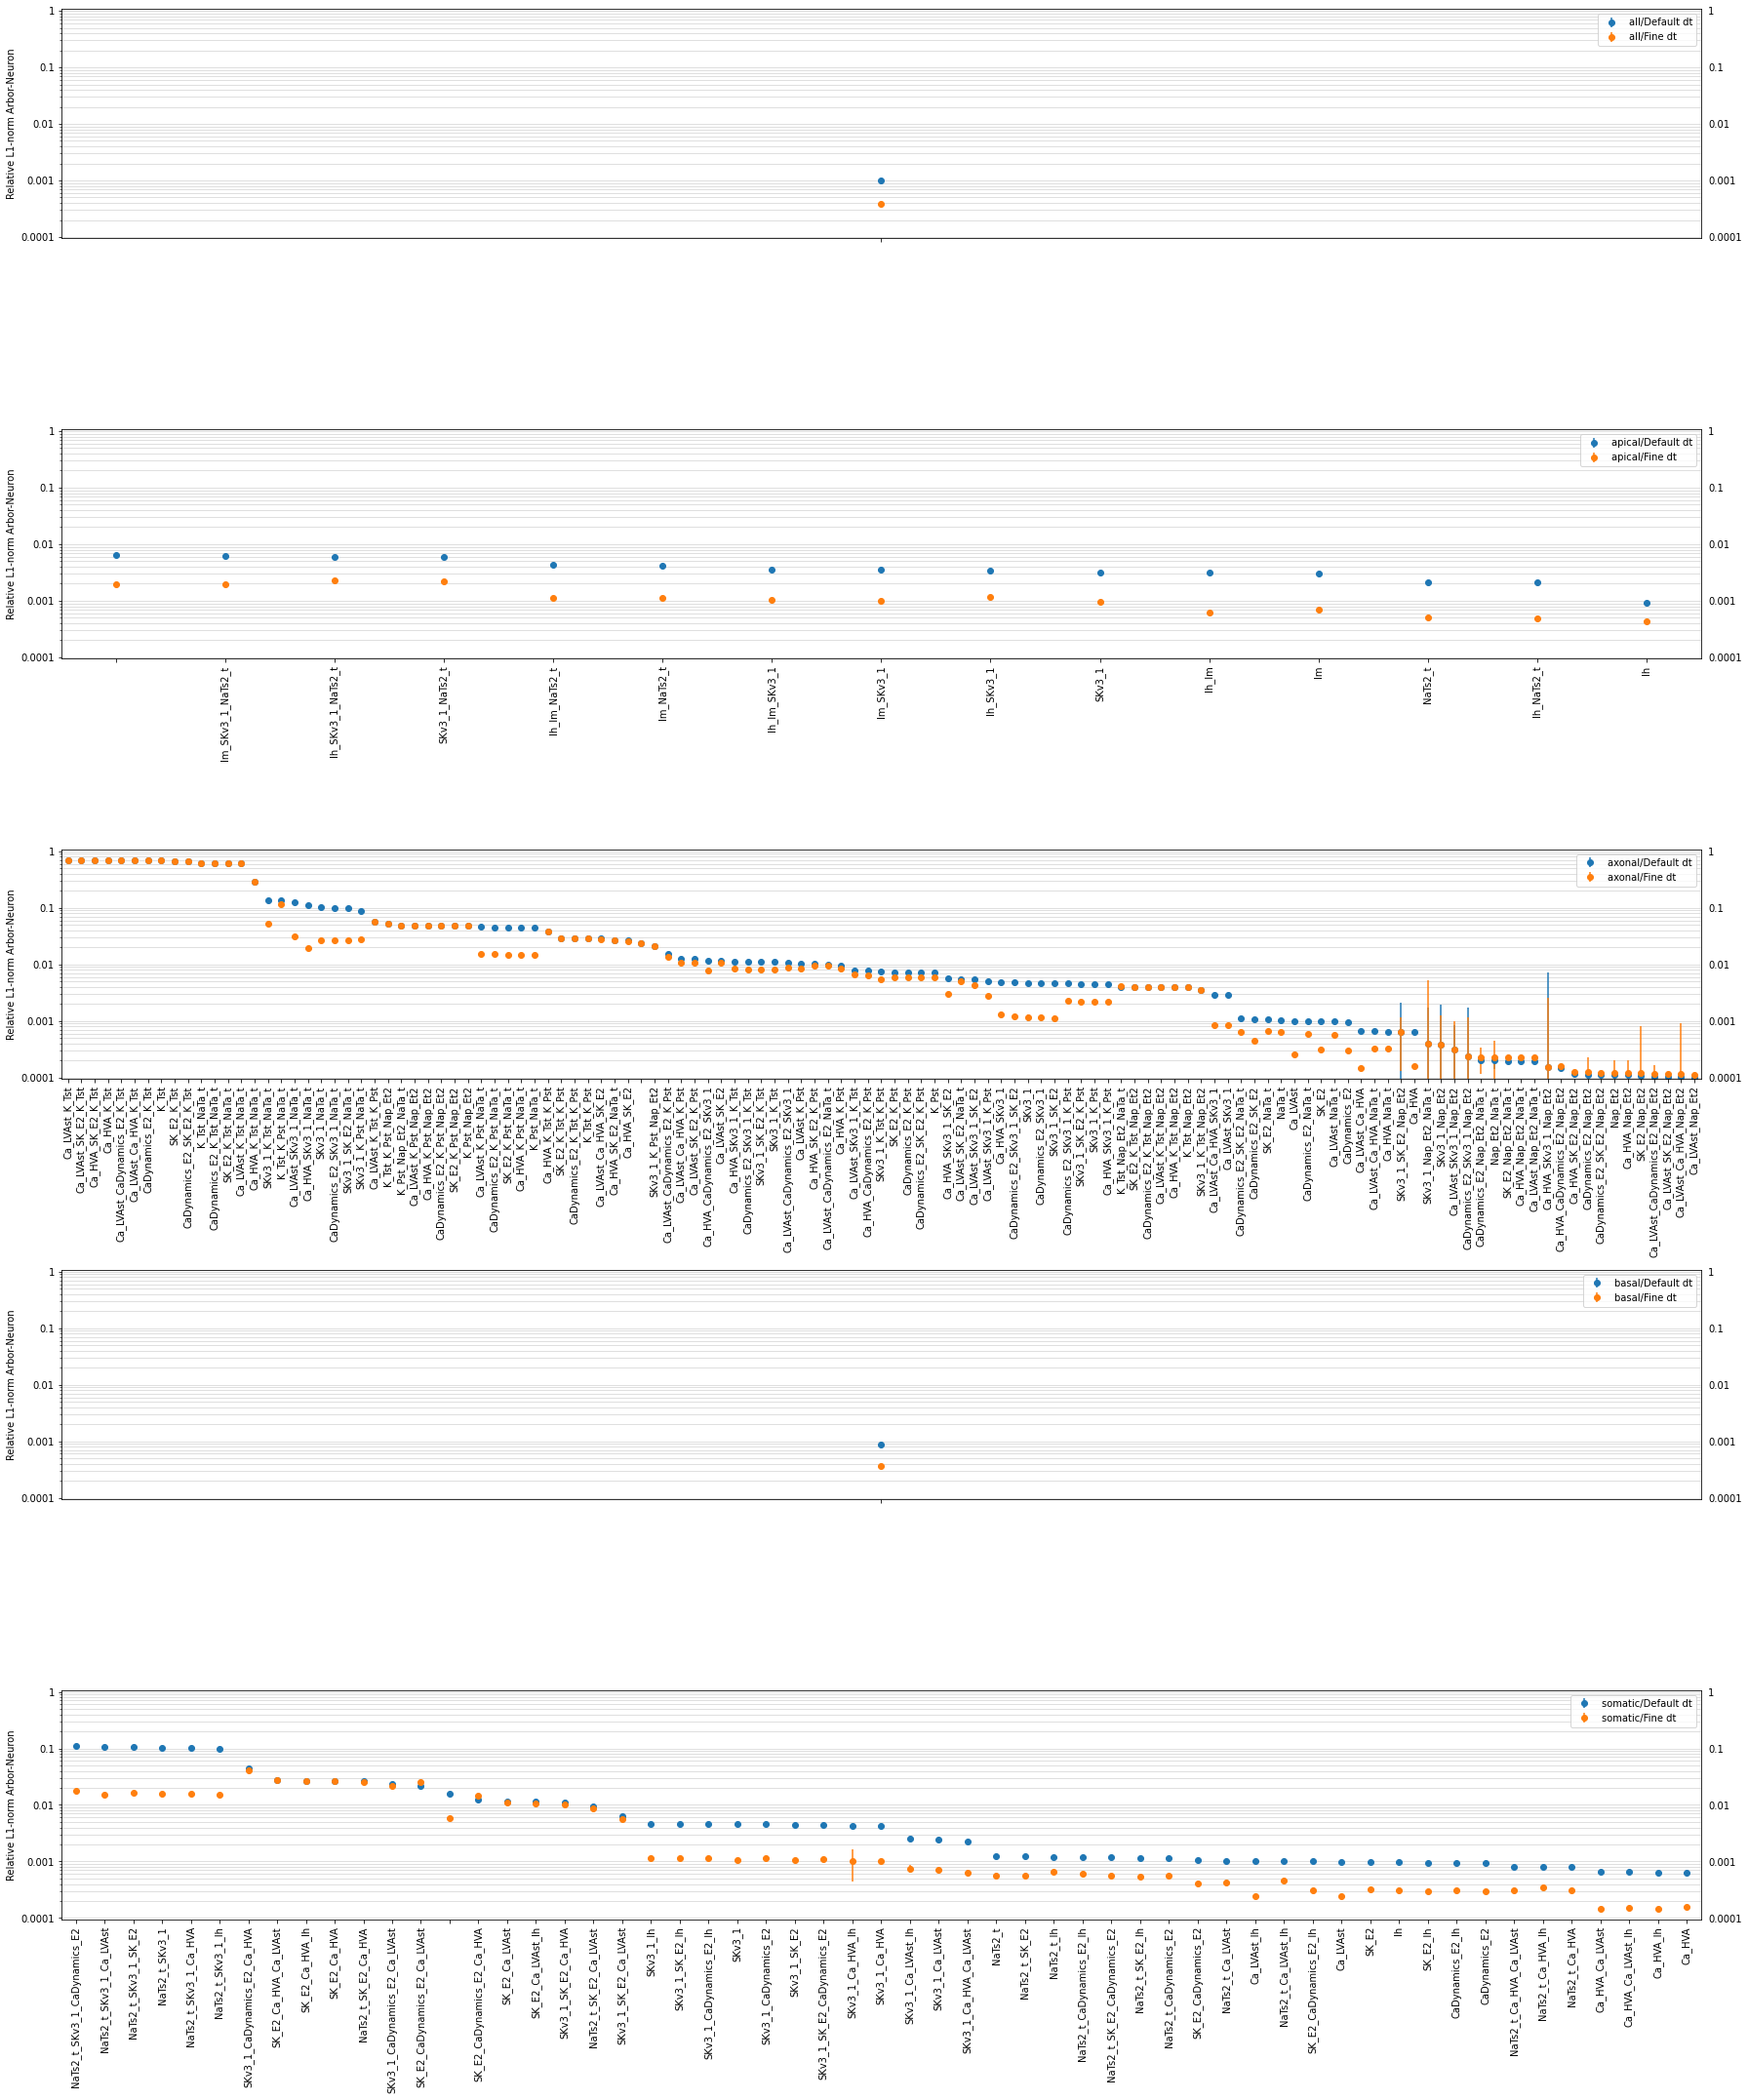

In [8]:
fig, axs = plt.subplots(len(regional_test_status), 1, sharey=True, figsize=(25, 6*len(regional_test_status)))

for i, (region, regional_test_status_df) in enumerate(regional_test_status.items()):
    for dt_setting, dt_group in regional_test_status_df.groupby('dt_setting'):
        axs[i].errorbar(dt_group['mechs_str'],
                          dt_group['l1_norm'], yerr=dt_group['l1_error'], fmt='o', label= region + '/' + dt_setting + ' dt')
        axs[i].tick_params(axis='x', labelrotation=90)
        axs[i].tick_params(labelright=True)
        axs[i].set_yscale('log')
        axs[i].yaxis.set_major_formatter(plt.FormatStrFormatter("%.2g"))
        axs[i].grid(visible=True, which='both', axis='y', alpha=0.5)
        axs[i].set_ylabel('Relative L1-norm Arbor-Neuron')
        axs[i].set_xlim(-0.5,len(dt_group)-0.5)
        axs[i].legend()
fig.tight_layout()
plt.show()

Tests with N/A result obtained above:

In [9]:
%%bash

cat tests_na

l5pc_soma_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb
l5pc_soma_arbor_axonal_Ca_HVA_CaDynamics_E2_K_Tst.ipynb
l5pc_soma_arbor_axonal_Ca_HVA_CaDynamics_E2_NaTa_t.ipynb
l5pc_soma_arbor_axonal_Ca_HVA_CaDynamics_E2_SK_E2.ipynb
l5pc_soma_arbor_axonal_Ca_LVAst_CaDynamics_E2.ipynb
l5pc_soma_arbor_axonal_Ca_LVAst_CaDynamics_E2_SK_E2.ipynb
l5pc_soma_arbor_axonal_Ca_LVAst_Ca_HVA_CaDynamics_E2.ipynb
l5pc_soma_arbor_somatic_CaDynamics_E2_Ca_HVA_Ca_LVAst.ipynb
l5pc_soma_arbor_somatic_CaDynamics_E2_Ca_HVA_Ih.ipynb
l5pc_soma_arbor_somatic_CaDynamics_E2_Ca_HVA.ipynb
l5pc_soma_arbor_somatic_CaDynamics_E2_Ca_LVAst_Ih.ipynb
l5pc_soma_arbor_somatic_CaDynamics_E2_Ca_LVAst.ipynb
l5pc_soma_arbor_somatic_NaTs2_t_CaDynamics_E2_Ca_HVA.ipynb
l5pc_soma_arbor_somatic_NaTs2_t_CaDynamics_E2_Ca_LVAst.ipynb


Usually this is due to failing to advance time-integration in NEURON. Printing all other cases here.

In [10]:
%%bash

for f in $(cat tests_na); do
    if ! grep NEURON:\ variable\ step\ integrator\ error $f > /dev/null; then
         echo $f
    fi
done

The error messages contain more info.

In [11]:
%%bash

grep -C 1 CVode $(cat tests_na)

l5pc_soma_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     "text": [
l5pc_soma_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb:      "CVode 0x3d4e0d0 simple_cell[0].soma[0] advance_tn failed, err=-7.\n"
l5pc_soma_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     ]
--
l5pc_soma_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     "text": [
l5pc_soma_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb:      "CVode-- At t = 84.7187 and h = 2.66851e-09, the corrector\n",
l5pc_soma_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-      "convergence failed repeatedly or with |h| = hmin.\n",
--
l5pc_soma_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     "text": [
l5pc_soma_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb:      "CVode 0x3d4e0d0 simple_cell[0].soma[0] advance_tn failed, err=-7.\n"
l5pc_soma_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     ]
--
l5pc_soma_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     "text": [
l5pc_soma_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb:      "CVode-- At t = 54.5933 and h = 1.83266e-09, the corrector\n",
l5pc_soma_arbor_